# FISH integrated analyses

<img src= /home/luisub/Desktop/FISH_Processing/docs/code_architecture.png alt="drawing" width="1000"/>

<img src= /Users/luisaguilera/Desktop/FISH_Processing/docs/code_architecture.png alt="drawing" width="1000"/>

## Libraries

In [1]:
# Importing libraries
import sys
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import pathlib
import warnings
warnings.filterwarnings("ignore")

## Directories Path

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

In [3]:
# Path
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('GAPDH_Exon_Cy5')     # path to a folder with images.
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('DUSP1_Cy5_norm_fbs_wo_DEX')
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('DUSP1_Cy5_norm_fbs_DEX_100nM_120min')
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('New_Oneil_Data')
data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('New_Oneil_Data_complete')


folder_name = data_dir.name
merge_images = 0 # this flag indicates if the images need to be merged

# Segmentation
channels_with_cytosol = [1,2,3]            # list or int indicating the channels where the cytosol is detectable
channels_with_nucleus =0                # list or int indicating the channels where the nucleus is detectable
channels_with_FISH = [2,3]               # list or int with the channels with FISH spots that are used for the quantification
diamter_nucleus = 250                    # approximate nucleus size in pixels
diameter_cytosol = 350              # approximate cytosol size in pixels

# Parameters for spot detection
voxel_size_z = 500                       # Microscope conversion px to nanometers in the z axis.
voxel_size_yx = 103                      # Microscope conversion px to nanometers in the xy axis.

psf_z_type_0 = 300                    # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers.
psf_yx_type_0 = 150                    # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers.

psf_z_type_1 = 300                    # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers.
psf_yx_type_1 = 150#90                    # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers.

list_voxels = [ [voxel_size_z, voxel_size_yx  ] ,  [voxel_size_z,voxel_size_yx ] ]
list_psfs = [ [psf_z_type_0 ,psf_yx_type_0] , [psf_z_type_1,psf_yx_type_1] ]

# Cluster Detection
minimum_spots_cluster = 2                # The number of spots in a neighborhood for a point to be considered as a core point (from which a cluster is expanded). This includes the point itself.
show_plots=True                          # Flag to display plots


In [4]:
# Detecting if images need to be merged
if merge_images == 1:
    list_file_names, list_images, number_images, output_to_path = fa.MergeChannels(data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =1).merge()
    data_dir = data_dir.joinpath('merged')

In [5]:
list_images, path_files, list_files_names, number_images = fa.ReadImages(data_dir).read()
list_images[2].shape

(18, 928, 624, 4)

 ____  ____   ___   ____ _____ ____ ____ ___ _   _  ____  
|  _ \|  _ \ / _ \ / ___| ____/ ___/ ___|_ _| \ | |/ ___| 
| |_) | |_) | | | | |   |  _| \___ \___ \| ||  \| | |  _  
|  __/|  _ <| |_| | |___| |___ ___) |__) | || |\  | |_| | 
|_|   |_| \_\\___/ \____|_____|____/____/___|_| \_|\____| 
                                                          
 ___ __  __    _    ____ _____        ___  
|_ _|  \/  |  / \  / ___| ____|  _   / _ \ 
 | || |\/| | / _ \| |  _|  _|   (_) | | | |
 | || |  | |/ ___ \ |_| | |___   _  | |_| |
|___|_|  |_/_/   \_\____|_____| (_)  \___/ 
                                           

ORIGINAL IMAGE
052121_Hela_CBS_GL2_48h_Flag TR_MCP JF646_100x_ - 1_c405_c488_c561_c640.tiff


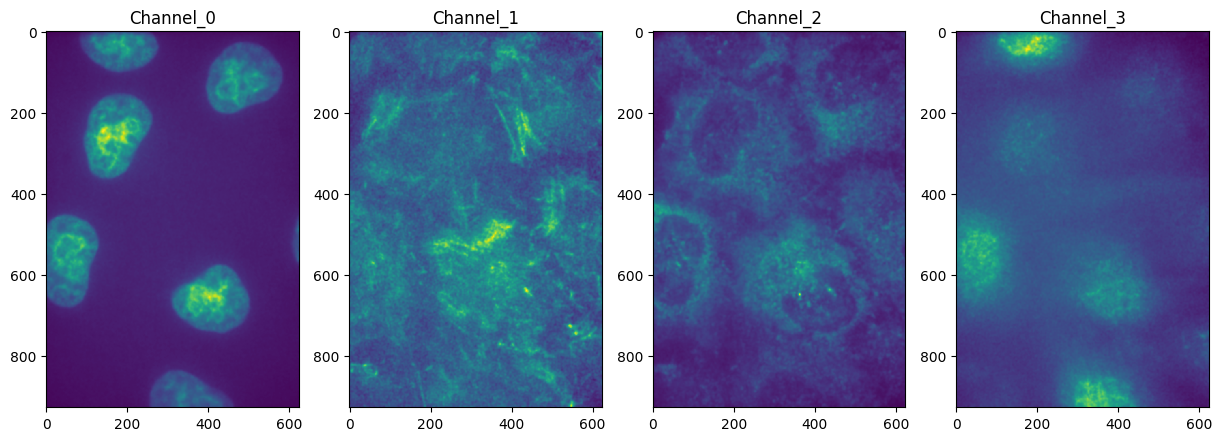

CELL SEGMENTATION
** TORCH CUDA version installed and working. **
>>>> using GPU


KeyboardInterrupt: 

In [6]:
dataframe_FISH = fa.PipelineFISH(data_dir, channels_with_cytosol, channels_with_nucleus, channels_with_FISH,diamter_nucleus, diameter_cytosol, minimum_spots_cluster,list_voxels=list_voxels, list_psfs=list_psfs, show_plot=show_plots,data_frame_name =folder_name ).run()

In [ ]:
dataframe_FISH.head()

In [ ]:
# Number of cells
spot_type_selected = 0

number_cells = dataframe_FISH['cell_id'].nunique()
print(number_cells)
# Number of spots
number_of_spots_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i)  & (dataframe_FISH['spot_type']==spot_type_selected) ].spot_id) for i in range(0, number_cells)]

# Number of spots in cytosol
number_of_spots_per_cell_cytosol = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) & (dataframe_FISH['is_nuc']==False) & (dataframe_FISH['spot_type']==spot_type_selected) ].spot_id) for i in range(0, number_cells)]

# Number of spots in nucleus
number_of_spots_per_cell_nucleus = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==False) & (dataframe_FISH['is_nuc']==True) & (dataframe_FISH['spot_type']==spot_type_selected)    ].spot_id) for i in range(0, number_cells)]

# Number of TS per cell
number_of_TS_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True) & (dataframe_FISH['spot_type']==spot_type_selected) ].spot_id) for i in range(0, number_cells)]
# Number of RNA in a TS
ts_size =  dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True)  & (dataframe_FISH['spot_type']==spot_type_selected)   ].cluster_size.values

# Size of each cell
cell_size = dataframe_FISH.loc[  (dataframe_FISH['spot_id']==0)  ].cell_area_px.values

In [ ]:
# Plotting intensity distributions
plt.style.use('ggplot')  # ggplot  #default
def plot_probability_distribution(data_to_plot, numBins = 10, title='', xlab='', ylab='', color='r', subplots=False, show_grid=True, fig=plt.figure() ):
  n, bins, patches = plt.hist(data_to_plot,bins=numBins,density=False,color=color)
  plt.xlabel(xlab, size=16)
  plt.ylabel(ylab, size=16)
  plt.grid(show_grid)
  plt.text(bins[(len(bins)//2)],(np.amax(n)//2).astype(int),'mean = '+str(round( np.mean(data_to_plot) ,1) ), fontsize=14,bbox=dict(facecolor='w', alpha=0.5) )
  plt.title(title, size=16)
  return (f)

In [ ]:
#Plotting
fig_size = (30, 7)
f = plt.figure(figsize=fig_size)
#ylab='Probability'
ylab='Frequency Count'  
# adding subplots
f.add_subplot(1,5,1) 
plot_probability_distribution( number_of_spots_per_cell, numBins=20,  title='Total Num Spots per cell', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,2) 
plot_probability_distribution(number_of_spots_per_cell_cytosol,   numBins=20,  title='Num Spots in Cytosol', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,3) 
plot_probability_distribution(number_of_spots_per_cell_nucleus, numBins=20,    title='Num Spots in Nucleus', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,4) 
plot_probability_distribution(ts_size, numBins=20,    title='Clusters in nucleus', xlab='RNA per Cluster', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,5) 
plot_probability_distribution(cell_size ,  numBins=20, title='Cell size', xlab='[Pixels]', ylab=ylab, fig=f, color='orangered')
plt.savefig('Figure_Distributions_'+folder_name)
plt.show()